# Run these three cells first:

In [2]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
#!/usr/bin/env python
from __future__ import division
from builtins import str
from builtins import range
from past.utils import old_div
import numpy as np
import datetime
import pickle
from netCDF4 import Dataset
import netCDF4
import sys
import matplotlib.pyplot as plt
from chaz import CLE15, utility
from pygplib3 import readbst
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
from pyproj import Proj, transform
from pygplib3 import landfall as ld
from wind_reconstruct.w_profile_2 import W_profile # from Qidong
from wind_reconstruct.w_profile import W_profile as W_profile_old # from Qidong
import math
import multiprocessing
from joblib import Parallel, delayed

In [3]:
# Bounding box for the USA
# Includes region of CONUS that is affected by North Atlantic TCs
lonmin = -105
latmin = 15
lonmax = -40 # consistent with extent of HWIND data
latmax = 50


# Initial subsetting of landfalling TCs over USA:
* Note: calling variables "phi" is vestige of developing the code for subsetting data over the Philippines.

In [4]:
# Load data from file

# Old file
# fileName = '/data2/clee/bttracks/Allstorms.ibtracs_all.v03r10.nc'
# ibtracs = readbst.read_ibtracs(fileName, 'wnp')

# New file
filename = '/data2/clee/bttracks/IBTrACS.ALL.v04r00.nc'
ibtracs = readbst.read_ibtracs_v4(filename,'atl',2) # gap = 2 to convert 3-hourly to 6-hourly

# Extract variables
lon = ibtracs.lon[:]
lon[np.where(lon>180)] -= 360 # correction so -180 to 180 rather than 0 to 360, and don't get weird jumps at lon=0
lat = ibtracs.lat[:]
wspd = ibtracs.wspd[:] # wind speed in knots
days = ibtracs.days[:] # date in days
dist2land = ibtracs.dist2land[:]
year = ibtracs.year[:]

# Load land-sea mask
llon, llat, ldmask = ld.get_landmask('/home/clee/CHAZ/landmask.nc')
llon2 = np.copy(llon)
llon2[np.where(llon2>180)] -= 360 # correction so -180 to 180 rather than 0 to 360, and don't get weird jumps at lon=0
land = np.max(ldmask)
ocean = np.min(ldmask)

/home/jbaldwin/lib/python/pygplib3/readbst.py:181: RuntimeWarning: invalid value encountered in less
  lon[lon<0]=lon[lon<0]+360
/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/scipy/io/netcdf.py:317: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


In [141]:
# Interpolate to 15-min timesteps
nscale = 24 # convert from 6-hr to 15-min timesteps (factor of 6*4=24)
lon_int = ld.rescale_matrix(lon,nscale,0) # int for time interpolated 
lat_int = ld.rescale_matrix(lat,nscale,0)
wspd_int = ld.rescale_matrix(wspd,nscale,0)
days_int = ld.rescale_matrix(days,nscale,0)

In [142]:
%%time
# Retrieve times of landfall for the USA/ North Atlantic
iSlandfall = ld.get_landfall_stormID(lon_int,lat_int,wspd_int,llon,llat,ldmask,land,np.min(ldmask))
landfall_times = ld.get_landfall_storm_time(iSlandfall,lon_int,lat_int,wspd_int,llon2,llat,ldmask,land,ocean,24)
nSlandfall_first = landfall_times[0] # index of storms that make first landfall (why different than nSlandfall?)
iTlandfall_first = landfall_times[1] # time of making first landfall
nSlandfall_all = landfall_times[2] # index of storms that make any landfall (ie storm would repeat if makes multiple landfalls)
iTlandfall_all = landfall_times[3] # time of making that landfall

CPU times: user 1min 3s, sys: 56.8 ms, total: 1min 3s
Wall time: 1min 3s


In [143]:
# Select storms making landfall in USA
nSlandfall_all_phi = []
iTlandfall_all_phi = []
for j in range(np.shape(nSlandfall_all)[0]):
    nS = nSlandfall_all[j]
    iT = iTlandfall_all[j]
    lon_landfall = lon_int[iT,nS]
    lat_landfall = lat_int[iT,nS]
    if lonmin <= lon_landfall <= lonmax and latmin <= lat_landfall <= latmax:
        nSlandfall_all_phi.append(nSlandfall_all[j])
        iTlandfall_all_phi.append(iTlandfall_all[j])

# Remove duplicate storms (storms that made landfall in the USA twice)
nSlandfall_phi = list(dict.fromkeys(nSlandfall_all_phi))
    

In [144]:
# Select data only for storms that make landfall in the USA
# (for normal timesteps and interpolated timestep data)
lon_phi = lon[:,nSlandfall_phi]
lat_phi = lat[:,nSlandfall_phi]
wspd_phi = wspd[:,nSlandfall_phi]
days_phi = days[:,nSlandfall_phi]
days_phi = np.where(days_phi==-99999., np.nan, days_phi)
year_phi = year[nSlandfall_phi]

lon_int_phi = lon_int[:,nSlandfall_phi]
lat_int_phi = lat_int[:,nSlandfall_phi]
wspd_int_phi = wspd_int[:,nSlandfall_phi]
days_int_phi = days_int[:,nSlandfall_phi]
days_int_phi = np.where(days_int_phi==-99999., np.nan, days_int_phi)

In [145]:
# Save out data of USA landfalling TCs
ds = xr.Dataset(
    {"lon": (("iT","nS"), lon_phi),
     "lat": (("iT","nS"), lat_phi),
     "wspd": (("iT","nS"), wspd_phi), # maximum sustained wind speed in m/s
     "days": (("iT","nS"), days_phi),
     "year": (("nS"), year_phi)},
        coords={
        "iT": np.arange(np.shape(lon_phi)[0]),
        "nS": np.arange(np.shape(lon_phi)[1]),
     },
 )

ds_int = xr.Dataset(
    {"lon": (("iT","nS"), lon_int_phi),
     "lat": (("iT","nS"), lat_int_phi),
     "wspd": (("iT","nS"), wspd_int_phi), # maximum sustained wind speed in m/s
     "days": (("iT","nS"), days_int_phi),
     "year": (("nS"), year_phi)},
        coords={
        "iT": np.arange(np.shape(lon_int_phi)[0]),
        "nS": np.arange(np.shape(lon_int_phi)[1]),
     },
 )

ds.to_netcdf("/home/jbaldwin/WorldBank/WIND_HAZARD/IBTRACS_LANDFALL_TRACKS/ibtracsv04r00_landfall_usa.nc", mode = 'w')
ds_int.to_netcdf("/home/jbaldwin/WorldBank/WIND_HAZARD/IBTRACS_LANDFALL_TRACKS/ibtracsv04r00_landfall_usa_15min.nc", mode = 'w')

# Start from here if subset data already:

In [4]:
# Load subset data of landfalling storms over Philippines
dat0 = xr.open_dataset("/home/jbaldwin/WorldBank/WIND_HAZARD/IBTRACS_LANDFALL_TRACKS/ibtracsv04r00_landfall_usa.nc")

# Select only years of the marketing data (1990-present)
year0 = np.array(dat0.year)
iT_start = np.where(year0==1990)[0][0]
iT_end = np.where(year0==2020)[0][-1]
dat = dat0.sel(nS = slice(iT_start,iT_end))

# Load variables
lon = np.array(dat.lon)
lat = np.array(dat.lat)
wspd = np.array(dat.wspd)/1.944 #convert from kts to m/s
days = np.array(dat.days)
year = np.array(dat.year)

# Load land-sea mask
llon, llat, ldmask = ld.get_landmask('/home/clee/CHAZ/landmask.nc')
llon2 = np.copy(llon)
llon2[np.where(llon2>180)] -= 360 # correction so -180 to 180 rather than 0 to 360, and don't get weird jumps at lon=0
land = np.max(ldmask)
ocean = np.min(ldmask)

/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/scipy/io/netcdf.py:317: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


In [5]:
# Calculate track angle and track translation speed 
er = 6371.0  # earth's radius; km
lon_diff = lon[1:, :]-lon[0:-1, :]
lat_diff = lat[1:, :]-lat[0:-1, :]
londis = old_div(2*np.pi*er*np.cos(old_div(lat[1:, :],180)*np.pi),360) # longitude distance at a latitude; km
dx = londis*1000*lon_diff # meters
dy = 110.*1000*lat_diff # meters
time_diff = (days[1:, :] - days[0:-1, :])*24.*60*60 # seconds
tr = old_div(np.sqrt(dx**2+dy**2),(time_diff)) # track translation speed
trDir = np.arctan2(lat_diff, lon_diff) # track angle
# note: subtraction cuts off point at end, might need to add one final track direction and speed point if get errors later

/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/past/utils/__init__.py:95: RuntimeWarning: divide by zero encountered in true_divide
  return a / b


In [6]:
# Interpolate to 15-min timesteps
nscale = 24 # convert from 6-hr to 15-min timesteps (factor of 6*4=24)
lon = ld.rescale_matrix(lon,nscale,0) # int for time interpolated 
lat = ld.rescale_matrix(lat,nscale,0)
wspd = ld.rescale_matrix(wspd,nscale,0)
days = ld.rescale_matrix(days,nscale,0)
tr = ld.rescale_matrix(tr,nscale,0)
trDir = ld.rescale_matrix(trDir,nscale,0)

In [7]:
# Further subsetting of data

# Remove points that don't have track speed/ direction calculation
tr_len = np.shape(tr)[0] # number of time points in track
lon2 = lon[:tr_len,:]
lat2 = lat[:tr_len,:]
wspd2 = wspd[:tr_len,:]
days2 = days[:tr_len,:]
tr2 = tr
trDir2 = trDir

# Make points farther east than 40W NaN
east_bound = -40
lon2 = np.where(lon2 > east_bound, np.nan, lon2) 
lat2 = np.where(lon2 > east_bound, np.nan, lat2)
wspd2 = np.where(lon2 > east_bound, np.nan, wspd2)
days2 = np.where(lon2 > east_bound, np.nan, days2)
tr2 = np.where(lon2 > east_bound, np.nan, tr2)
trDir2 = np.where(lon2 > east_bound, np.nan, trDir2)


/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


Text(0.5, 1.0, '1990-2020 Storm Tracks Subset (15 min data)')

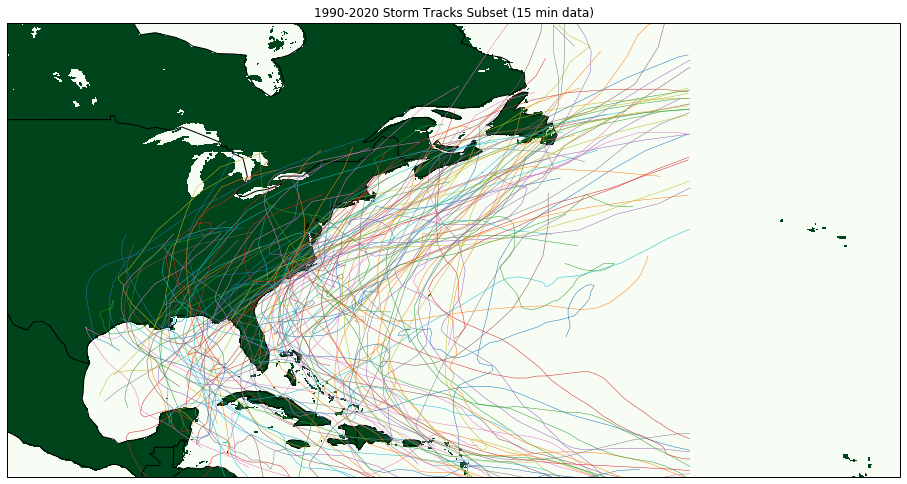

In [8]:
# Plotting tracks and landfall locations

plt.figure(figsize=(16, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(llon2,llat,ldmask,cmap=plt.cm.Greens)

for nS in range(np.shape(lon)[1]):
    plt.plot(lon2[:,nS],lat2[:,nS],linewidth=0.5)#,marker='.')

ax.set_extent([lonmin,-20,latmin,latmax])
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title('1990-2020 Storm Tracks Subset (15 min data)')

In [9]:
# Aggregate only storm points (lat,lon,wspd) where might be making landfall
wspd_landfall = []
lon_landfall = []
lat_landfall = []
days_landfall = []
tr_landfall = []
trDir_landfall = []
year_landfall = []

for nS in range(np.shape(lon)[1]):
    
    # Index to remove NaN points
    notnan_index = ~np.isnan(wspd2[:,nS])
    
    # Subset data to remove NaN points
    wspd_landfall.append(wspd2[notnan_index,nS])
    lon_landfall.append(lon2[notnan_index,nS])
    lat_landfall.append(lat2[notnan_index,nS])
    days_landfall.append(days2[notnan_index,nS])
    tr_landfall.append(tr2[notnan_index,nS])
    trDir_landfall.append(trDir2[notnan_index,nS])

In [10]:
# Distance function
# Center of storm = lat, lon
# Calculate distance between center point and each grid point
# adopted from: https://kite.com/python/answers/how-to-find-the-distance-between-two-lat-long-coordinates-in-python
# radius of earth in km so outputs distance in km

def distancefrompoint(lon, lat, X1, Y1):
    R = 6371.0 #radius of the Earth km

    lat1 = math.radians(lat)
    lon1 = math.radians(lon)
    lat2 = np.radians(Y1)
    lon2 = np.radians(X1)

    # change in coordinates
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Set up function to run wind fields in parallel
# 32 processors total available

# Calculate wind field with asymmetry, subtracting max rFactor*vt from wspdi before calculating profile:
def windfield(lon_nS,lat_nS,wspd_nS,rmax_nS,tr_nS,trDir_nS,i):
    loni = lon_nS[i]
    lati = lat_nS[i]
    wspdi = wspd_nS[i]
    rmaxi = rmax_nS[i]
    tri = tr_nS[i]
    trDiri = trDir_nS[i]
    
    # Calculate tangential wind
    angle = np.arctan2((Y1-lati),(X1-loni)) - trDiri # define angle relative to track direction 
    vt = -tri*np.cos(np.pi/2 - angle) # calculate tangential wind; remove minus if southern hemisphere
    
    # Calculate distance from center of storm
    distance = distancefrompoint(loni, lati, X1, Y1) # distance in km
    
    # Round distance values to nearest whole number
    distance = distance.astype(int)
    
    # Calculate rFactor to modulate track correction
    rFactor = utility.translationspeedFactor(old_div(distance,rmaxi))
    asymcorrec = rFactor*vt
    max_asymcorrec = 0.7*tri # 0.7 from utility.translationspeedFactor structure. tri = max vt. Alternatively could do np.max(rFactor)*np.max(vt), but this should be faster and more exact.
    
    # Calculate Willoughby Profile
    radius_max = 500
    radius_precision = 1
    profile = W_profile(lati, rmaxi, wspdi-max_asymcorrec, radius_max, radius_precision) # subtracting the maximum value of the trackspeed correction from the windspeed that is input to the Willoughby profile; this ensures that the maximum windspeed of the windfield is not higher than that in ibtracs.
    radius = np.arange(0,radius_max + radius_precision, radius_precision)
    
    # Create dict look-up table from Willoughby Profile
    wspdlookup = dict(zip(radius, profile))

    # Remap radii to windspeed
    wspdmap = np.zeros(np.shape(distance))
    for r in radius:
        wspdmap[np.where(distance == r)] = wspdlookup[r]
    
    #Add track direction correction
    wspdmap = wspdmap + asymcorrec
    
    # Set to 0 outside radius_max
    wspdmap[np.where(distance > radius_max)] = 0 # added 10-27-20
    
    #wspdmaps.append(wspdmap)
    
    return wspdmap

In [11]:
# Define x-y grid to put profile on

# bounds from nanmin and nanmax on lon2 and lat2
X = np.arange(-98,east_bound+0.1,0.1)
Y = np.arange(8,70+0.1,0.1)
X1, Y1 = np.meshgrid(X,Y)


In [12]:
%%time

#CURRENT
missed_tries = 0
for nS in [2]:#[katrina_nS,sandy_nS]: #np.arange(390,len(wspd_landfall),1):
    print(nS)
    
    # Select data for 1 storm
    wspd_nS = wspd_landfall[nS][:]
    lon_nS = lon_landfall[nS][:]
    lat_nS = lat_landfall[nS][:]
    days_nS = days_landfall[nS][:]
    tr_nS = tr_landfall[nS][:]
    trDir_nS = trDir_landfall[nS][:]
    
    # Calculate radius of maximum wind
    rmax_nS = utility.knaff15(wspd_nS*1.944, lat_nS)  #  wspd should be input in kts, outputs in km
    rmax_min = 20 # minimum rmax used if Knaff15 produces values that are unrealistically small; km
    rmax_nS[np.where(rmax_nS<rmax_min)] = rmax_min # 6-12-20: set places with radii less than 0 to 20 km to fix convergence
    
    # Calculate wind fields in parallel
    stormpoints = np.shape(wspd_nS)[0]
    try:
        wspdmaps = Parallel(n_jobs=16, prefer="threads")(delayed(windfield)(lon_nS,lat_nS,wspd_nS,rmax_nS,tr_nS,trDir_nS,i) for i in range(stormpoints))    
        wspdmaps = np.expand_dims(wspdmaps,axis = 0)
        wspdmaps = np.abs(wspdmaps) # take absolute value for places asymmetry correction overpowers wind speed
    
        # Create dataset
        ds = xr.Dataset(
         {"wspd": (("nS", "iT","lat", "lon"), wspdmaps),
          "days": (("nS","iT"), np.expand_dims(days_nS,axis=0)),
          "year": (("nS"), [year[nS]])},
             coords={
            "nS":np.array([nS]),
            "iT":np.arange(stormpoints),
            "lat": Y,
            "lon": X,
         },
         )
    
        #Write to netcdf
        ds.to_netcdf('/data2/jbaldwin/WINDFIELDS/IBTRACS/USA_TEST/wspd_usa_'+str(nS).zfill(3)+'.nc',mode='w',unlimited_dims = ["nS"])
    except:
        missed_tries += 1

101
CPU times: user 33min 33s, sys: 44min, total: 1h 17min 34s
Wall time: 2min 34s


# Extra Step: Load and examine the resulting wind fields:

Text(0.5, 1.0, 'Wind Field at One Point in Time')

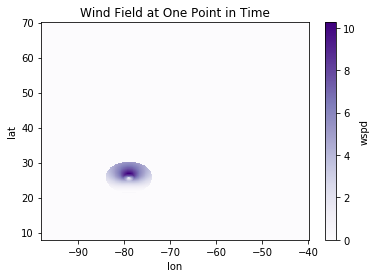

In [34]:
nS = 2
xr.open_dataset('/data2/jbaldwin/WINDFIELDS/IBTRACS/USA_WINDFIELDS/wspd_usa_'+str(nS).zfill(3)+'.nc').sel(iT=20).sel(nS=nS).wspd.plot(cmap=plt.cm.Purples)
plt.title('Wind Field at One Point in Time')

In [27]:
np.min(xr.open_dataset('/data2/jbaldwin/WINDFIELDS/IBTRACS/USA_WINDFIELDS/wspd_usa_'+str(nS)+'.nc').sel(iT=30).sel(nS=nS).wspd)

<xarray.DataArray 'wspd' ()>
array(-0.341206)
Coordinates:
    nS       int64 2
    iT       int64 30

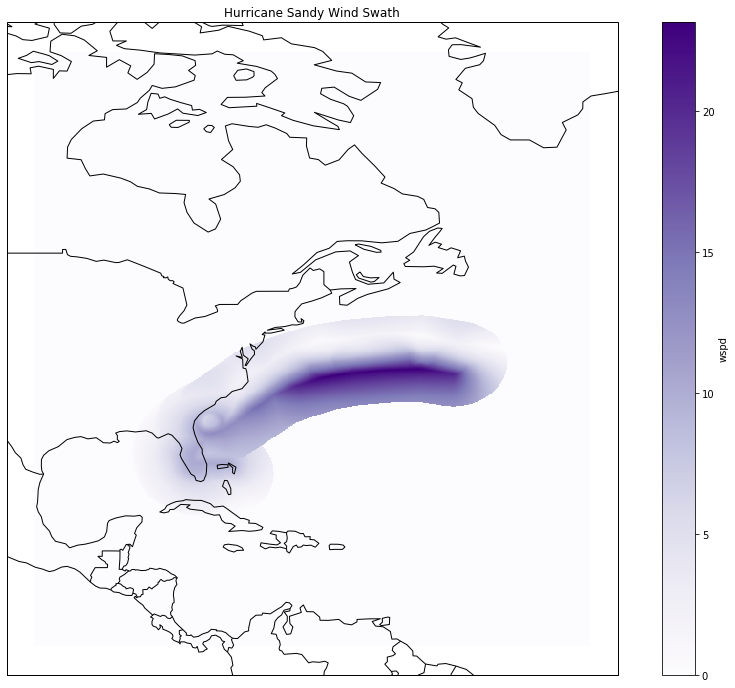

In [35]:
nS = 2
plt.figure(figsize=(16, 12))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
xr.open_dataset('/data2/jbaldwin/WINDFIELDS/IBTRACS/USA_WINDFIELDS/wspd_usa_'+str(nS).zfill(3)+'.nc').max(dim='iT').sel(nS=nS).wspd.plot(cmap=plt.cm.Purples)
plt.title('Hurricane Sandy Wind Swath')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# Landfall test.

In [120]:
%%time
# Retrieve times of landfall for the North Atlantic
iSlandfall = ld.get_landfall_stormID(lon,lat,wspd,llon,llat,ldmask,land,np.min(ldmask))
landfall_times = ld.get_landfall_storm_time(iSlandfall,lon,lat,wspd,llon2,llat,ldmask,land,ocean,24)
nSlandfall_first = landfall_times[0] # index of storms that make first landfall (why different than nSlandfall?)
iTlandfall_first = landfall_times[1] # time of making first landfall
nSlandfall_all = landfall_times[2] # index of storms that make any landfall (ie storm would repeat if makes multiple landfalls)
iTlandfall_all = landfall_times[3] # time of making that landfall

CPU times: user 6.51 s, sys: 14 ms, total: 6.53 s
Wall time: 6.52 s


Text(0.5, 1.0, '1990-2020 Storm Landfall Locations (15 min data)')

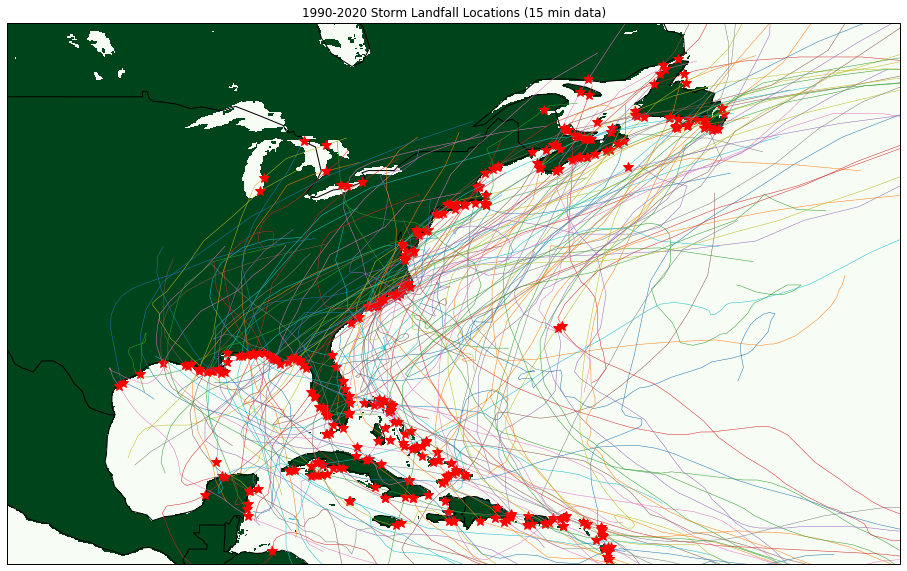

In [134]:
# Plotting tracks and landfall locations

plt.figure(figsize=(16, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(llon2,llat,ldmask,cmap=plt.cm.Greens)

for nS in range(np.shape(lon)[1]):
    yy = np.where(nSlandfall_all==nS)
    plt.plot(lon[:,nS],lat[:,nS],linewidth=0.5)#,marker='.')
    for i in iTlandfall_all[yy]:
        plt.plot(lon[i,nS],lat[i,nS],'*',color='r',markersize=10)

ax.set_extent([lonmin,lonmax,latmin,latmax])
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title('1990-2020 Storm Landfall Locations (15 min data)')

 # CODE SCRAPS FOR LATER

In [210]:
# Convert modified Julian days to date-time objects
nmax = 116
dt = []
month = np.zeros(nmax)
day = np.zeros(nmax)
year = np.zeros(nmax)
for n in np.arange(0,nmax,1):
    mjd = days_landfall[n][0]
    x = julian.from_jd(mjd, fmt='mjd').date()
    dt.append(x)
    month[n] = int(x.month)
    day[n] = int(x.day)
    year[n] = int(x.year)
    
katrina_nS = dt.index(datetime.date(2005, 8, 23))
sandy_nS = dt.index(datetime.date(2012, 10, 23))

NameError: name 'julian' is not defined

In [4]:
for nS in [0]:#range(115):
    swath = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/IBTRACS/USA_WINDFIELDS/wspd_usa_'+str(nS).zfill(3)+'.nc').max(dim='iT').wspd


In [9]:
for i in range(2):
    print(i)

0
1


In [7]:
test = np.empty([115,621,581])

In [26]:
# Calculate wind swaths and save out
nmax = 116
swath = np.zeros([nmax,621,581])
day1 = np.zeros([nmax])
year = np.zeros([nmax])
for nS in range(nmax):
    ds_haz = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/IBTRACS/USA_WINDFIELDS/wspd_usa_'+str(nS).zfill(3)+'.nc')
    swath[nS,...] = ds_haz.sel(nS=nS).max(dim='iT').wspd # calculate max across time points
    day1[nS] = ds_haz.days[0,0]
    year[nS] = ds_haz.year
    
# Save out dataset of swaths
ds_swaths = xr.Dataset(
         {"swath": (("nS", "lat", "lon"), swath),
          "day1": (("nS"), day1),
          "year": (("nS"), year)},
             coords={
            "nS":np.arange(0,nmax,1),
            "lat": ds_haz.lat,
            "lon": ds_haz.lon,
         },
         )

In [31]:
ds_swaths.to_netcdf('/data2/jbaldwin/WINDFIELDS/IBTRACS/USA_SWATHS/wspd_usa_swaths.nc')


In [ ]:
# Create swath dataset
ds = xr.Dataset(
    {"swath": (("nS", "lat", "lon"), swath),
    "days": (("nS","iT"), np.expand_dims(days_fornc,axis=0)),
    "year": (("nS"), [year[nS]])},
        coords={
        "nS":np.array([nS]),
        "iT":np.arange(stormpoints),
        "lat": Y,
        "lon": X,
    },
    )